# Hypertension Prediction Project - Midterm Notebook

## 1. Introduction

In this notebook, we aim to predict the risk of hypertension for individuals based on various health parameters. Hypertension, also known as high blood pressure, is a condition that significantly increases the risk of heart disease, stroke, and other health problems. The goal of this study is to build a machine learning model that can effectively classify individuals as being at risk for hypertension. We will follow the standard process of data analysis, which includes data preparation, exploratory data analysis (EDA), feature engineering, model training, evaluation, and selection.

## 2. Data Preparation

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from tqdm.auto import tqdm
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

data = './hypertension_dataset.csv'
!head $data

df = pd.read_csv(data)
df.head(10)

NumMedicalVisits,Cholesterol,BloodPressure,PhysicalActivity,SodiumIntake,BMI,HypertensionPedigreeFunction,Age,Outcome
6,290,109,125,3361,27.5,0.83,31,0
3,286,172,233,4356,32.8,0.14,74,0
10,176,170,7,2705,24.1,0.93,74,0
7,271,151,128,2185,24.7,2.36,25,1
4,154,162,263,3351,35.4,1.6,25,0
6,178,115,156,4935,27.8,1.68,44,0
9,232,155,4,1687,35.6,1.58,79,1
2,285,162,85,3119,36.1,0.5,29,1
6,258,162,174,3187,36.9,1.05,18,0


,NumMedicalVisits,Cholesterol,BloodPressure,PhysicalActivity,SodiumIntake,BMI,HypertensionPedigreeFunction,Age,Outcome
0,6,290,109,125,3361,27.5,0.83,31,0
1,3,286,172,233,4356,32.8,0.14,74,0
2,10,176,170,7,2705,24.1,0.93,74,0
3,7,271,151,128,2185,24.7,2.36,25,1
4,4,154,162,263,3351,35.4,1.60,25,0
5,6,178,115,156,4935,27.8,1.68,44,0
6,9,232,155,4,1687,35.6,1.58,79,1
7,2,285,162,85,3119,36.1,0.50,29,1
8,6,258,162,174,3187,36.9,1.05,18,0
9,10,214,129,289,2484,38.2,1.88,60,1


## 3. Exploratory Data Analysis (EDA)

In [5]:
df.columns
df.info()
df.describe()

df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NumMedicalVisits              650 non-null    int64  
 1   Cholesterol                   650 non-null    int64  
 2   BloodPressure                 650 non-null    int64  
 3   PhysicalActivity              650 non-null    int64  
 4   SodiumIntake                  650 non-null    int64  
 5   BMI                           650 non-null    float64
 6   HypertensionPedigreeFunction  650 non-null    float64
 7   Age                           650 non-null    int64  
 8   Outcome                       650 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 45.8 KB


NumMedicalVisits                0
Cholesterol                     0
BloodPressure                   0
PhysicalActivity                0
SodiumIntake                    0
BMI                             0
HypertensionPedigreeFunction    0
Age                             0
Outcome                         0
dtype: int64

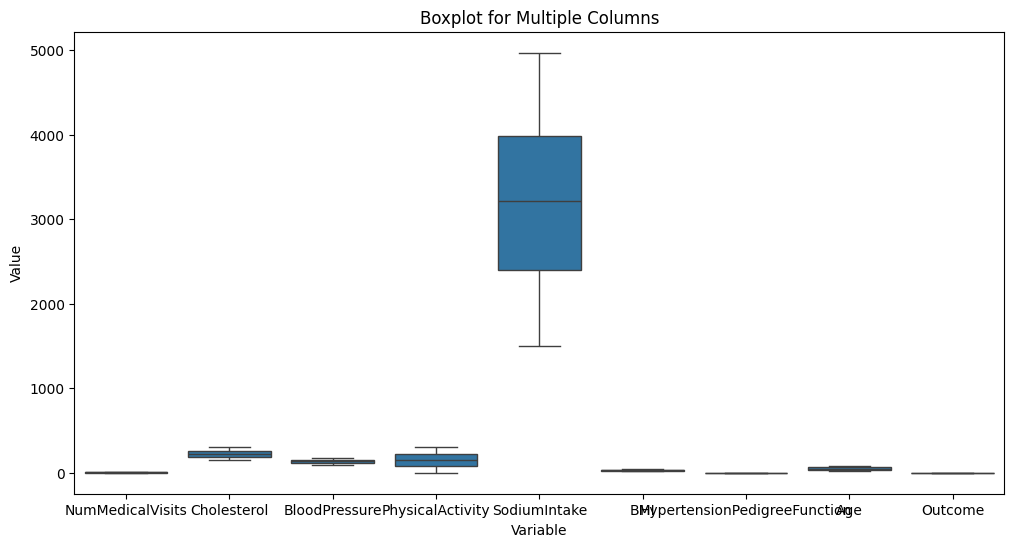

In [6]:
def show_boxplot(df):
    df_melted = df.melt(var_name='Variable', value_name='Value')
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Variable', y='Value', data=df_melted)
    plt.title('Boxplot for Multiple Columns')
    plt.show()

show_boxplot(df)

## 4. Data Cleaning and Feature Engineering

In [7]:
def remove_outliers_iqr(df, column):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

df = remove_outliers_iqr(df, 'BloodPressure')
df = remove_outliers_iqr(df, 'Age')
df = remove_outliers_iqr(df, 'BMI')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NumMedicalVisits              650 non-null    int64  
 1   Cholesterol                   650 non-null    int64  
 2   BloodPressure                 650 non-null    int64  
 3   PhysicalActivity              650 non-null    int64  
 4   SodiumIntake                  650 non-null    int64  
 5   BMI                           650 non-null    float64
 6   HypertensionPedigreeFunction  650 non-null    float64
 7   Age                           650 non-null    int64  
 8   Outcome                       650 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 45.8 KB
